# Analysis Hotel Booking Demand

## Packages

In [70]:
from custom_functions.models import *
from custom_functions.data_exploration import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_numeric_dtype, is_string_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import make_scorer, cohen_kappa_score
import hyperopt
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from boruta import BorutaPy
import pickle
pd.set_option('display.max_rows', 100)

# Dataset

In [71]:
df_original = pd.read_csv('hotel_bookings.csv')
df_original.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Exploratory Data Analysis (EDA) Part 1

In [ ]:
# We use the custom functions that are in the module data_exploration to get insights 
# about our variables, in particular regarding the null values and the distributions. 
# These functions save the results in the folders plots and values_counts_csv
value_counts_csv(df_original)
count_nulls(df_original)
distributions(df_original)

## Remarks for every variable
These are the first observations about the variables obtained looking at the distributions (using the previous custom functions)
- <b>hotel</b>: 2 values: City Hotel (66%), Resort Hotel (34%)
- <font color='orange'>is_canceled</font>: (dependent variable) 2 values: 0 (62%) and 1 (38%).The dataset is unbalanced.
- <font color='orange'>lead_time</font>: The distibution has a long right tail. We could consider to group the values.
- <font color='orange'>arrival_date_year</font>: 3 years. We could eliminate this info if we use a smaller time granularity.
- <font color='orange'>arrival_date_month</font> We have more arrival in the summer
- <font color='orange'>arrival_date_week_number</font>: This variable can incorporate well the seasonality of the arrivals.
- <font color='orange'>arrival_date_day_of_month</font>: We could eliminate this variable and keep just the week number.
- <font color='orange'>stays_in_weekend_nights</font>: Long left tail. We can Consider just 0,1,2 and group the bigger vslues.
- <font color='orange'>stays_in_week_nights</font>:  Long left tail. We can Consider just 0,1,2 and group the bigger values.
- <font color='orange'>adults</font>: We have to decide what to do with the 0 value. We could keep group together values <= 3.
- <font color='orange'>children</font>: 93% is 0. 4 nulls.We could just put 0 (no childrens) and 1 (childrens).
- <font color='orange'>babies</font>: 99% is 0. We could eliminate this variable.
- <font color='orange'>meal</font>: Three relevat classes BB (77%), HB (12%) and SC(8%).
- <font color='orange'>country</font>: 488 nulls. 6 relevat countries: PRT 41%, GBR 10%, FRA 9%, ESP 7%, DEU 6%, ITA 3%. We can put the others countries together. 
- <font color='orange'>market_segment</font>: 5 relevant classes, Online TA 47%, Offline TA/TO 20%, Groups 17%, Direct 10% and Corporate 4.4%
- <font color='orange'>distribution_channel</font>: Similar to market segment, but market segment more defined.
- <font color='orange'>is_repeated_guest</font>: The majority of the custumers are new (97%).
- <font color='orange'>previous_cancellations</font>: Two relevant classes, 0 is about 95% and 1 is about 5%. 
- <font color='orange'>previous_bookings_not_canceled</font>: We can eliminate this column since it is related to the previous.
- <font color='orange'>reserved_room_type</font>: 4 relevant classes, A is 72%, D is 16%, E is 5%, F is 2.4 %
- <font color='orange'>assigned_room_type</font>: It would  be interesting to know when a customer know the assigned_room_type. 
- <font color='orange'>booking_changes</font>: We can use just three classes 0, 1 and >1.
- <font color='orange'>deposit_type</font>: Only 3 classes, No deposit 87%, Non Refund 12% and Refundable 1%
- <font color='orange'>agent</font>:  13% nulls. There a lot of values. We will not consider this information for the moment.
- <font color='orange'>company</font>:  94% nulls. We eliminate sice we are not sure of the meaning of the nulls.
- <font color='orange'>days_in_waiting_list</font>: We will create just two classes for 0 days and >0. 
- <font color='orange'>customer_type</font>: There 4 classes. We could group the two smaller ones. 
- <font color='orange'>adr</font>: There some ouliers we should take care of. 
- <font color='orange'>required_car_parking_spaces</font>: Just two relevant classes 0 and 1. We can transformed this in a binary variable.
- <font color='orange'>total_of_special_requests</font>: We can creat just three classes 0, 1 and >1.
- <font color='orange'>reservation_status</font>: We will not consdier this information, cause we want to predict it when the customer does the reservation.
- <font color='orange'>reservation_status_date</font>: We eliminate this cause we want to make the prediction at the tyme the customer did the reservation. 


# Feature engineering
Based on the previous comments we are going to do some cleaning of the dataset.
We are going to group the values and take care of outliers and null values.

In [73]:

df = df_original.copy()

# lead_time: put more than 1 year to 365 days 
df['lead_time']= np.where(df['lead_time']>365, 365, df['lead_time'])

# arrival_date_month: eliminate this coulum cause we have this information already in the week_number
df.drop('arrival_date_month', axis = 1, inplace = True)

# Group the week by 2 
df['arrival_date_week_number'] = (df['arrival_date_week_number'] + 1 ) // 2

# arrival_date_day_of_month
df.drop('arrival_date_day_of_month', axis = 1 ,inplace = True)

# stays_in_weekend_nights
df['stays_in_weekend_nights']= np.where(df['stays_in_weekend_nights']>2, 3, df['stays_in_weekend_nights'])

# stays_in_week_nights
df['stays_in_week_nights']= np.where(df['stays_in_week_nights']>5, 6, df['stays_in_week_nights'])

# adults
df['adults']= np.where(df['adults']>2, 3, df['adults'])
df['adults'].replace(0, df['adults'].median(), inplace = True)

# children
df['children'] = np.where(df['children']>0,1, 0)
df['children'].replace(np.nan, 0, inplace = True)

# eliminate babies 
df.drop('babies', axis = 1, inplace=True)

# meal
# We merge Undefined with SC and full breakfast with half breakfast.
df['meal'].replace({'FB': 'HB','Undefined':'SC'}, inplace=True)

# country
country = pd.read_csv('value_counts_csv/country.csv')
df['country'] = np.where(df['country'].isin(country.iloc[0:6, 0].to_list()), df['country'],'Others')

# Market_segment and distribution_channel

# We have studied the relation of the two variables with the following table:
# df.groupby(['market_segment','distribution_channel']).size().unstack()) 
# And we decided to keep market_segment cause is more detailed

df.drop('distribution_channel', axis = 1, inplace = True)
df['market_segment'] = np.where(df['market_segment'].isin(['Complementary','Aviation', 'Undefined']), df['market_segment'], 'Others')

# previous_cancellations
df['previous_cancellations'] = np.where(df['previous_cancellations']>0,1, 0)

# previous_bookings_not_canceled
df.drop('previous_bookings_not_canceled', axis = 1, inplace = True)

# reserved_room_type
df['reserved_room_type'] = np.where(df['reserved_room_type'].isin(['A','D', 'E','F']), df['reserved_room_type'] , 'Others')

# assigned_room_type
df.drop('assigned_room_type', axis = 1, inplace = True)

# booking_changes: We have put everything greater than 1 to 2
df['booking_changes']= np.where(df['booking_changes']>1,2,df['booking_changes'])


# deposit_type: we have join Refundable with No Deposit
df['deposit_type'].replace({'Refundable':'No Deposit'},inplace = True)

# agent
df.drop('agent', axis = 1, inplace = True)

# company
df.drop('company', axis = 1, inplace = True)

# days_in_waiting_list
df['days_in_waiting_list'] = np.where(df['days_in_waiting_list']>0,1,0)

# adr: We eliminate this variable cause we are not sure about what is it and if it is a posteriori information.
df.drop('adr', axis = 1 , inplace = True)

# required_car_parking_spaces: we make this variable binary
df['required_car_parking_spaces'] = np.where(df['required_car_parking_spaces'] >0,1,0)

# total_of_special_requests
df['total_of_special_requests'] = np.where(df['total_of_special_requests'] >1,2,df['total_of_special_requests'])

# reservation_status
df.drop('reservation_status', axis = 1, inplace = True)

# reservation_status_date 
df.drop('reservation_status_date', axis = 1, inplace = True)

EDA (Part 2)

# Correlation and association of the variables
we have three types of correlations and associations to consider:

- numerical vs numerical: we use the Pearson correlation (range [-1,1])
- categorical vs numerical: we use the Eta correlation (it is related to the Anova test, its range is [0,1])
- categorical vs categorical: we use the Cramer's V association (related to the chi-squared test, its range is [0,1])

<AxesSubplot:title={'center':'correlation and association matrix'}>

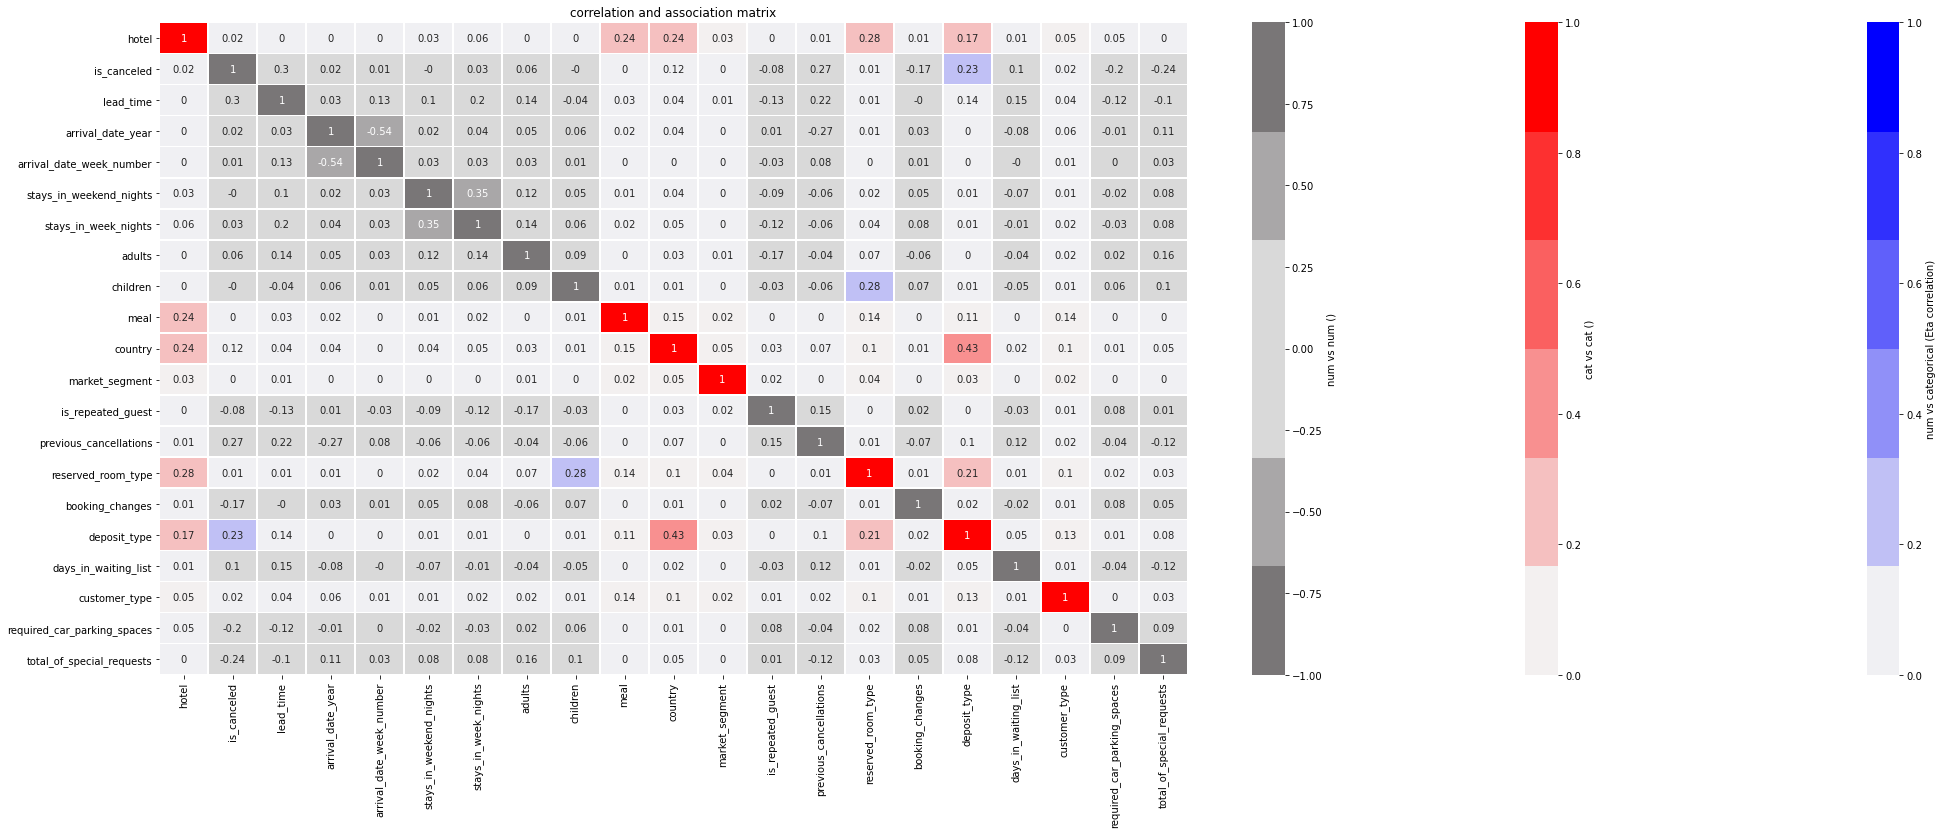

In [76]:
matrix = correlation_matrix(df)
matrix_mask=matrix[1]
matrix1 = matrix[0]
matrix1 = pd.DataFrame(matrix1)
matrix1 = np.around(matrix1,2)
matrix1.columns = df.columns 
matrix1.set_index(df.columns, inplace = True)

mask_num = np.where(matrix_mask == 1, False, True)
mask_cat = np.where(matrix_mask == 2 , False, True)
mask_mixed = np.where(matrix_mask == 3 , False, True)

cm_blue = sns.light_palette("blue", as_cmap=False)
cm_red = sns.light_palette("red", as_cmap= False)
cm_green = sns.light_palette("green", as_cmap= False)
cm_div = sns.diverging_palette( h_neg=1,h_pos=1, s=1, as_cmap=False)

plt.figure(figsize=(36, 12))
plt.title("correlation and association matrix")
sns.heatmap(matrix1, annot=True, mask=mask_mixed, cmap=cm_blue, vmax = 1, vmin=0, linewidths = .7, cbar_kws={'label': "num vs categorical (Eta correlation)"})
sns.heatmap(matrix1, annot=True, mask=mask_cat, cmap=cm_red,linewidths = .7, vmax = 1, vmin = 0, cbar_kws={'label': "cat vs cat ()"})
sns.heatmap(matrix1, annot=True, mask=mask_num, cmap=cm_div, vmax=1, vmin=-1, linewidths = .7,cbar_kws={'label': "num vs num ()"})


Looking at the table we don't find variables that are stongly associated. In particular we were interested in absolute values greater than 0.75. 

# Divide our data in training and test

In [77]:
X = df.copy()
y = df['is_canceled']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state = 345, stratify = y )

# Stratified mean encoding 

We are going to transform the 7 categorical features that we have (hotel, meal, country, market_segment, reserved_room_type, deposit_type and customer_type). Since we have a binary classification problem we are used a mean encoding with CV loops for regolarization. 

In [78]:
cols = df.columns[df.dtypes == object].tolist() # colums that I want to change
X_train = X_train_orig.copy() # Here I am going to put the new variables 
X_test = X_test_orig.copy() 

# Just to avoid an annoying warning
pd.options.mode.chained_assignment = None 

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
for tr_ind, val_ind in skf.split(X_train_orig, y_train_orig):
    X_tr , X_val = X_train_orig.iloc[tr_ind] ,X_train_orig.iloc[val_ind]
    for col in cols:
        value = X_val.loc[:,col].map(X_tr.groupby(col).is_canceled.mean())
        X_train.loc[X_train_orig.index[val_ind], col] = value
        X_train_orig.loc[X_train_orig.index[val_ind], col+'_new'] = value
total_ratio = X_train.loc[:,'is_canceled'].mean()
X_train.fillna(total_ratio, inplace = True)


In [79]:
for col in cols:
    value = X_test_orig[col].map(X_train_orig.groupby(col)[col +'_new'].mean())
    X_test[col]= value
X_test.fillna(total_ratio, inplace = True)

# Features importance


We are going to use a Recursive Features Elimination (with Random Forest) to study the importances of our features

In [80]:
X = X_train
y = X_train['is_canceled']
X = X.drop('is_canceled', axis = 1 )

model_rf = RandomForestClassifier()
rfecv = RFECV(estimator= model_rf, step=1, cv=StratifiedKFold(5, random_state = 123, shuffle = True),  scoring='accuracy', n_jobs = -1, verbose = 1)

# uncomment the following line if the model is not saved yet.
#rfecv.fit(X, y)
#if not os.path.exists('models'):
   # os.makedirs('value_counts_csv')
filename = 'models/rfecv'
#pickle.dump(rfecv, open(filename, 'wb'))
rfecv = pickle.load(open(filename, 'rb'))
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 19


In the following graph we can see the plot of number of features versus validation score.

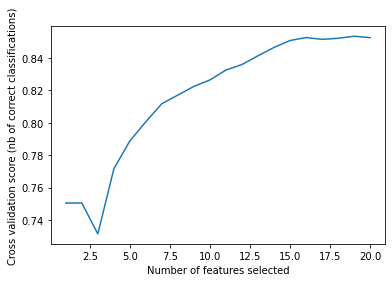

In [81]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In the following table we can see which are the variable considered less important by the model and the score we obtain when we add them.

In [82]:
num_feature = rfecv.n_features_
tab_rank = pd.DataFrame ({ 'rank' : rfecv.ranking_ , 'variables': X.columns.tolist()} )
tab_rank = pd.DataFrame(tab_rank.groupby('rank').variables.apply(list))
tab_rank['score'] = rfecv.grid_scores_[num_feature-1 : len(rfecv.grid_scores_)].tolist()
print(tab_rank)

                                              variables     score
rank                                                             
1     [hotel, lead_time, arrival_date_year, arrival_...  0.853411
2                                [days_in_waiting_list]  0.852532


In the following table we can see the importance of every variable.

In [10]:
tab_imp = pd.DataFrame({'variables' : X.columns[rfecv.support_], 'importance': rfecv.estimator_.feature_importances_ }) 
tab_imp = tab_imp.sort_values('importance', ascending=False)
print(tab_imp)

                      variables  importance
1                     lead_time    0.195768
15                 deposit_type    0.141765
9                       country    0.118742
3      arrival_date_week_number    0.104332
5          stays_in_week_nights    0.055602
16                customer_type    0.046998
18    total_of_special_requests    0.046207
13           reserved_room_type    0.035691
2             arrival_date_year    0.035401
4       stays_in_weekend_nights    0.035362
12       previous_cancellations    0.034149
8                          meal    0.028545
0                         hotel    0.026404
17  required_car_parking_spaces    0.025318
14              booking_changes    0.022823
6                        adults    0.020584
10               market_segment    0.010846
7                      children    0.009537
11            is_repeated_guest    0.005927


- We see that lead_time, deposit_type, country ans arrival_date_week_number are the most important varibles.
- We decide to keep the variable suggested by the random forest, so we eliminate days_in_waiting_list. 

In [11]:
rows = tab_rank.shape[0]
if rows != 1:
    for j in range(1,rows):
        list_columns = tab_rank.iloc[j,0]
        for i in list_columns:
            X_train.drop(i, axis = 1, inplace = True)
            X_test.drop(i, axis = 1, inplace = True)

# Feature scaling

We have used a min-max transformation for all the variables.

In [12]:
scaler = MinMaxScaler()
X_train.drop("is_canceled", axis = 1, inplace = True)
X_test.drop("is_canceled", axis = 1, inplace = True)
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# Modelling 

We will use the xgboost and logistic regression. First we have tries these two models with the defaults parameters later we will do some iperparameters tuning.

##  XGboost default parameters

In [31]:
y_train = y_train_orig.copy()
y_test = y_test_orig.copy()
filename = "models/model_xgboost_default"
model_xgboost_default = pickle.load(open(filename,'rb'))

In [16]:
# uncomment the following lines if the model is not saved

#model_xgboost_default = classifier_gridCV(X_train, y_train, X_test = X_test,  y_test = y_test, cv = 5, scoring = "accuracy", params = {}, clf = xgb.XGBClassifier(), model_name = "xgboost_default")
filename = "models/model_xgboost_default"
# pickle.dump(model_xgboost_default, open(filename, 'wb'))
model_xgboost_default = pickle.load(open(filename,'rb'))

The best parameters from grid are: {}
The parameters of the best model are:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
The results on the test are:
Precision = 0.842118496872502
Recall = 0.8210155408243187
Accuracy = 0.8452131669319038


Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

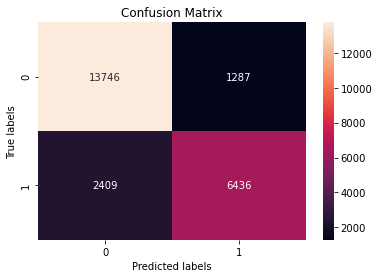

In [32]:
pred_xgboost = model_xgboost_default.predict(X_test)
# plot of confusion matrix of the test 
cm=metrics.confusion_matrix(y_test,pred_xgboost)
classes = model_xgboost_default.classes_
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

Kappa di Cohen 

In [33]:
cohen_score = cohen_kappa_score(y_test, pred_xgboost)
print("The Cohen's K score is: ", cohen_score)

The Cohen's K score is:  0.6592424270891379


We have improved our baseline that was an accuracy of 62% (Percetange of the most frequent class). 

## Logistic Regression default parameters

In [65]:
#uncomment the following lines if the model is not saved
#model_logistic_default = classifier_gridCV(X_train, y_train, X_test = X_test,  y_test = y_test, cv = 3, scoring = "accuracy", params = {}, clf = linear_model.LogisticRegression(solver='liblinear'), model_name = "logistic_default")
filename = "models/model_logistic_default"
#pickle.dump(model_logistic_default, open(filename, 'wb'))
model_logistic_default = pickle.load(open(filename,'rb'))

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

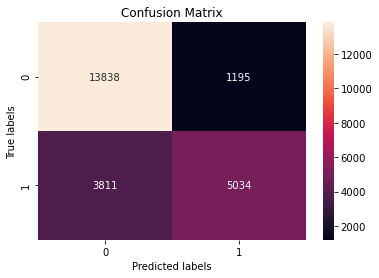

In [66]:
pred_logistic = model_logistic_default.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred_logistic)
classes = model_logistic_default.classes_
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

In [67]:
# Cohens score
cohen_score = cohen_kappa_score(y_test, pred_logistic)
print("The Cohen's K score is: ", cohen_score)

The Cohen's K score is:  0.5213805779170115


With the logistic regression we obtain worst results.

## ROC curve of the models

We compare the two models also looking at the ROC curve. 

AUC xgboost: 0.9233751809708108
AUC logistic regression: 0.8565329104310446


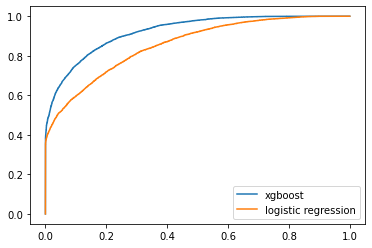

In [68]:
# We predict the probabilities with xgboost

pred_xgboost_prob = model_xgboost_default.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, pred_xgboost_prob, pos_label=1)
auc_xgb = np.trapz(tpr_xgb,fpr_xgb)
print('AUC xgboost:', auc_xgb)

# We predic the probabilities with the logistic regression
pred_logistic_prob = model_logistic_default.predict_proba(X_test)[:,1]
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, pred_logistic_prob, pos_label=1)
auc_log = np.trapz(tpr_log,fpr_log)
print('AUC logistic regression:', auc_log)

# Print ROC curve
plt.plot(fpr_xgb,tpr_xgb, label = 'xgboost')
plt.plot(fpr_log,tpr_log, label = 'logistic regression')
plt.legend()
plt.show()

#roc_auc_score(y_test, pred_logistic_prob)

# XGBoost: Hyperparameter tunig 
## Coarse to fine approach (using Hyperopt)

We are going to do the parameters tuning using an approach called Coarse to fine. We will

- Assign a distribution to each of the parameter we want to analyse.(Uniform distribution)
- Test combination of these parameters using an optimizer TPE in order to minimize the loss. 
- We will look at the results to find some interesting regions in the parameters space.
- We will perform some Grid search with the best values found.

For computational limitation, we check 50 

In [35]:
# we decided to look at the depth of the tree, the learning rate and the n_estimators. 
space = {
    'max_depth' : hp.uniform ('max_depth', 5, 25 ),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 1 ),
    'n_estimators' : hp.uniform('n_estimators', 100, 200)
}

In [36]:
def objective(params):
    params2 = {
        'max_depth' : [int(params['max_depth'])],
         #'min_samples_leaf' : int(params['min_samples_leaf']),
        'learning_rate' : [params['learning_rate']],
        'n_estimators' : [int(params['n_estimators'])]
        #'min_child_weight' : [params['min_child_weight']]
     }
    grid = GridSearchCV(xgb.XGBClassifier(), params2,scoring= 'accuracy',cv= 5)
    model = grid.fit(X_train, y_train)
    mean_score = model.cv_results_["mean_test_score"][0]
    loss = 1- mean_score
    return loss


In [37]:
trials = Trials()
# uncomment the following lines if the model is not saved.
filename = "models/trials_xgboost"
#pickle.dump(trials_xgboost, open(filename, 'wb'))
trialsxgboost = pickle.load(open(filename,'rb'))
#best_result = fmin( 
              #fn = objective,
              #space = space,
              #trials = trials,
              #max_evals = 100,
              #rstate = np.random.RandomState(42),
              #algo = tpe.suggest)

100%|██████████| 100/100 [1:57:17<00:00, 70.38s/trial, best loss: 0.1473008242303694] 


In [47]:
learning_rate = [t['misc']['vals']['learning_rate'][0] for t in trials.trials ]
accuracy =[1-t['result']['loss'] for t in trials.trials ]
best_accuracy = max(accuracy)
print( "The best accuracy is " + str(best_accuracy))

The best accuracy is 0.8526991757696306


We have improved the accuracy of our model by 0.1. 
Now we are going to look at the parameters space. 

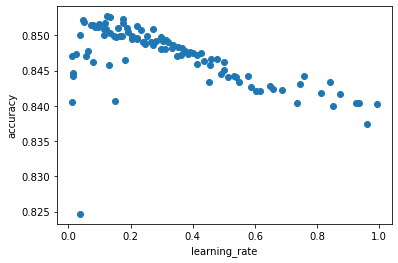

In [50]:
learning_rate = [t['misc']['vals']['learning_rate'][0] for t in trials.trials ]
accuracy =[1-t['result']['loss'] for t in trials.trials ]
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.scatter(learning_rate, accuracy)

We see that the best results are obtained with a learning rate between 0.05 and 0.15.

In [51]:
#min_child_weight = [t['misc']['vals']['min_child_weight'][0] for t in trials.trials ]
#plt.xlabel('min_child_weight')
#plt.ylabel('accuracy')
#plt.scatter(min_child_weight, accuracy)

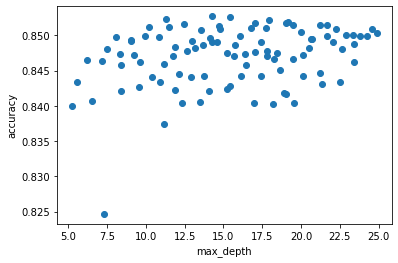

In [52]:
max_depth = [t['misc']['vals']['max_depth'][0] for t in trials.trials ]
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.scatter(max_depth, accuracy)

It seems that the best results are achived with a depth between 11 and 18.

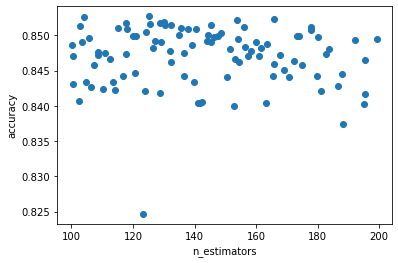

In [53]:
n_estimators = [t['misc']['vals']['n_estimators'][0] for t in trials.trials ]
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.scatter(n_estimators, accuracy)

We don't see a clear pattern in the data however, it seems that it is enough consider between 100 and 160 estimators.

The following are all the combinations that we have tried. 

In [56]:
best_parameters_xgb = pd.DataFrame({'maxdepth' : max_depth, 'n_estimators' : n_estimators,  'learning_rate' : learning_rate, 'accuracy' : accuracy}).sort_values(by ='accuracy',ascending=False )
print(best_parameters_xgb)

     maxdepth  n_estimators  learning_rate  accuracy
34  14.258440    125.207996       0.123723  0.852699
40  15.404760    104.103407       0.134581  0.852647
90  11.289838    165.840361       0.175679  0.852364
76  17.908053    153.724888       0.046792  0.852176
67  19.188283    130.193709       0.050493  0.851830
25  17.042332    128.875376       0.176241  0.851799
75  19.038988    117.699031       0.117017  0.851799
70  12.460892    125.595085       0.099130  0.851663
0   21.652641    145.470105       0.078361  0.851485
23  21.186953    130.458013       0.099781  0.851443
68  19.485431    132.443693       0.071362  0.851401
26  14.704269    102.724829       0.221344  0.851390
78  11.496598    177.700640       0.084669  0.851181
61  10.228772    156.123387       0.095080  0.851129
32  17.764609    135.674662       0.159593  0.851024
65  16.770158    115.044294       0.187633  0.850982
22  24.558849    140.345674       0.115447  0.850919
89  22.267551    137.958496       0.121996  0.

## Grid search with the best parameters

In [57]:
# We select some interesting parameters and we try the combination between them. 
params = { 'max_depth' : [11, 12, 13,15, 17, 19],
    'learning_rate' : [0.05,0.1, 0.125, 0.15],
    'n_estimators' : [100, 125 ,150]}

In [59]:
model_xgboost_tuned = classifier_gridCV(X_train, y_train, X_test = X_test,  y_test = y_test, cv = 3, scoring = "accuracy", params = params, clf = xgb.XGBClassifier(), model_name = "xgboost_tuned")


The best parameters from grid are: {'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 125}
The parameters of the best model are:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=17,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
The results on the test are:
Precision = 0.8525564266255468
Recall = 0.8388817636812353
Accuracy = 0.8577770332523662


In [61]:
check = model_xgboost_tuned

In [62]:
filename = "models/model_xgboost_tuned"
pickle.dump(model_xgboost_tuned, open(filename,'wb'))
model_xgboost_tuned = pickle.load(open(filename,'rb'))

# confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

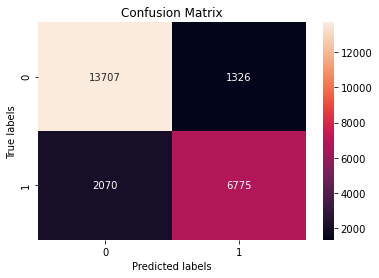

In [63]:
pred_xgboost_tuned = model_xgboost_tuned.predict(X_test)
cm=metrics.confusion_matrix(y_test,pred_xgboost_tuned)
classes = model_xgboost_tuned.classes_
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d'); 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [64]:
# Cohen's kappa
cohen_score = cohen_kappa_score(y_test, pred_xgboost_tuned)
print("The Cohen's K score is: ", cohen_score)

The Cohen's K score is:  0.6897037475597224


With the grid search, we have managed to improve the accuracy of the model by 0.005. It would be possible to expore further the parameter space but for the moment we stop here. 
The best accuracy obtained is then 0.858

# THE END 